In [1]:
from tensorflow.keras.models import Sequential
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from keras.models import Model
from keras.layers import *
import tensorflow as tf
import cv2
from sklearn.model_selection import train_test_split
import numpy as np
import pandas as pd
from tensorflow.keras.utils import plot_model
import re
from tensorflow.keras.preprocessing.sequence import pad_sequences
tf.config.run_functions_eagerly(True)

In [3]:
class PositionalEncoding(Layer):
    def __init__(self, d_model):
        super(PositionalEncoding, self).__init__()
        self.d_model = d_model

    def call(self, inputs):
        seq_length = tf.shape(inputs)[1]  # Get sequence length dynamically

        # Generate position indices (0, 1, 2, ..., seq_length-1)
        position = tf.range(seq_length, dtype=tf.float32)[:, tf.newaxis]

        # Compute the positional encoding using broadcasting
        i = tf.range(self.d_model, dtype=tf.float32)[tf.newaxis, :]
        angle_rates = 1 / tf.pow(10000.0, (2 * (i // 2)) / tf.cast(self.d_model, tf.float32))
        angle_rads = position * angle_rates

        # Apply sin to even indices and cos to odd indices
        pos_encoding = tf.concat([tf.sin(angle_rads[:, 0::2]), tf.cos(angle_rads[:, 1::2])], axis=-1)
        pos_encoding = pos_encoding[tf.newaxis, ...]

        # Add positional encoding to input embeddings
        return inputs + pos_encoding

# **Encoder**

In [4]:
# seq_length ---------> Maximum number of words in a sentence throughtout dataset.
# d_model ------------> Dimensions of one vector
# vocab_words = ------> Total number of unique words in dataset

class Encoder(Model):
  def __init__(self, seq_length, d_model, vocab_words):
    super(Encoder, self).__init__()
    self.seq_length = seq_length
    self.d_model = d_model
    self.vocab_words = vocab_words

    self.embedding = Embedding(self.vocab_words, self.d_model, )
    self.positional_encoding = PositionalEncoding(self.d_model)
    self.multi_head_attention = MultiHeadAttention(1, self.d_model)
    self.layer_norm = LayerNormalization()
    self.dense = Dense(64, activation='relu')
    self.fcl_output = Dense(self.d_model, activation='softmax')
    self.layer_norm_2 = LayerNormalization()
    # plot_model(self)

  def call(self, inputs):
    x = self.embedding(inputs)
    x = self.positional_encoding(x)
    attn_x = self.multi_head_attention(x, x)
    x = self.layer_norm(x + attn_x)
    dense = self.dense(x)
    output = self.fcl_output(dense)
    x = self.layer_norm_2(x + output)
    return x

encoder = Encoder(4, 3, 15)
encoder_input = Input(shape=(4,))
encoder(encoder_input)
print(encoder.summary())

Model: "encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, 4, 3)                │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding                  │ ?                           │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ multi_head_attention                 │ (None, 4, 3)                │              48 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization                  │ (None, 4, 3)                │               6 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 4, 3)                │             195 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_1                │ (None, 4, 3)                │               6 │
│ (LayerNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 556 (2.17 KB)

 Trainable params: 556 (2.17 KB)

 Non-trainable params: 0 (0.00 B)

None


# **Decoder**

In [5]:
# Hum dost hain ------------> [2, 5, 1]
# Maine saeb khata hoon ----> [3, 4, 6]

class Decoder(Model):
  def __init__(self, seq_length, d_model, vocab_words):
    super(Decoder, self).__init__()
    self.seq_length = seq_length
    self.d_model = d_model
    self.vocab_words = vocab_words

    self.embedding = Embedding(self.vocab_words, self.d_model)
    self.positional_encoding = PositionalEncoding(self.d_model)
    self.masked_multi_head_attention = MultiHeadAttention(1, self.d_model, name = "Masked_MultiHead_Attention")
    self.layer_norm = LayerNormalization()
    self.cross_attention = MultiHeadAttention(1, self.d_model, name = "Cross_Attention")
    self.layer_norm_2 = LayerNormalization()
    self.dense = Dense(64, activation='relu')
    self.fcl_output = Dense(self.d_model, activation='softmax')
    # self.project_to_d_model = Dense(d_model)
    self.layer_norm_3 = LayerNormalization()

  def create_look_ahead_mask(self, seq_length):
    return tf.linalg.band_part(tf.ones((seq_length, seq_length)), -1, 0)

  def call(self, decoder_input, encoder_output):
    embedding = self.embedding(decoder_input)
    pe = self.positional_encoding(embedding)
    attn_mask = self.create_look_ahead_mask(tf.shape(pe)[1])
    mmha = self.masked_multi_head_attention(pe, pe, attention_mask = attn_mask)
    layer_norm = self.layer_norm(pe + mmha)
    multi_h_a = self.cross_attention(layer_norm, encoder_output)
    layer_norm_2 = self.layer_norm_2(layer_norm + multi_h_a)
    fcl = self.dense(layer_norm_2)
    output = self.fcl_output(fcl)
    # output = self.project_to_d_model(output) # To make shape of d_model
    layer_norm_3 = self.layer_norm_3(layer_norm_2 + output)
    return layer_norm_3

decoder = Decoder(4, 3, 15)
decoder_input = Input(shape=(4,))
encoder_output = Input(shape=(4, 3))
decoder(decoder_input, encoder_output)
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, 4, 3)                │              45 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ positional_encoding_1                │ ?                           │               0 │
│ (PositionalEncoding)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Masked_MultiHead_Attention           │ (None, 4, 3)                │              48 │
│ (MultiHeadAttention)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_2                │ (None, 4, 3)                │               6 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ Cross_Attention (MultiHeadAttention) │ (None, 4, 3)                │              48 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_3                │ (None, 4, 3)                │               6 │
│ (LayerNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 4, 64)               │             256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 4, 3)                │             195 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ layer_normalization_4                │ (None, 4, 3)                │               6 │
│ (LayerNormalization)                 │                             │                 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 610 (2.38 KB)

 Trainable params: 610 (2.38 KB)

 Non-trainable params: 0 (0.00 B)

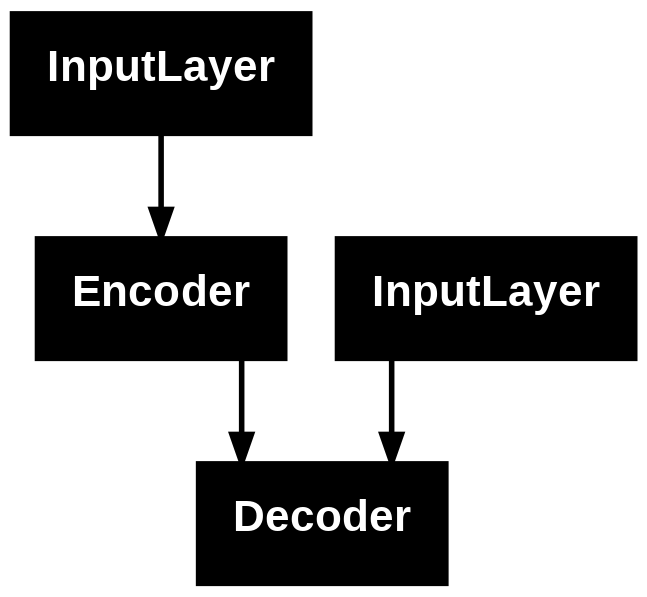

In [18]:
encoder_input = Input(shape=(seq_length,))
decoder_input = Input(shape=(seq_length,))
encoder = Encoder(seq_length, d_model, vocab_size)(encoder_input)
decoder = Decoder(seq_length, d_model, vocab_size)(decoder_input, encoder)
transformer = Model(inputs=[encoder_input, decoder_input], outputs=decoder)
plot_model(transformer)

In [20]:
transformer.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [8]:
df = pd.read_csv("/content/drive/My Drive/English-French.csv")

In [9]:
def clean_text(text):
    text = text.lower()
    text = re.sub(r"[^a-zA-ZÀ-ÿ0-9.!?']+", " ", text)
    text = text.strip()
    return text

In [10]:
df["English words/sentences"] = df["English words/sentences"].apply(clean_text)
df["French words/sentences"] = df["French words/sentences"].apply(clean_text)
df["French words/sentences"] = df["French words/sentences"].apply(lambda x: "<start> " + x + " <end>")

In [11]:
eng_tokenizer = Tokenizer()
fr_tokenizer = Tokenizer()

eng_tokenizer.fit_on_texts(df["English words/sentences"])
fr_tokenizer.fit_on_texts(df["French words/sentences"])

eng_sequences = eng_tokenizer.texts_to_sequences(df["English words/sentences"])
fr_sequences = fr_tokenizer.texts_to_sequences(df["French words/sentences"])

In [12]:
# vocab words
len((eng_tokenizer.word_index).keys()) + len((fr_tokenizer.word_index).keys())

41500

In [13]:
print(len(max(eng_sequences)))
print(len(max(fr_sequences)))

16
24


In [19]:
seq_length = 24
d_model = 64
vocab_words = 41500

In [15]:
eng_rows = pad_sequences(eng_sequences, maxlen=24, padding='post')
fr_rows = pad_sequences(fr_sequences, maxlen=24, padding='post')

In [16]:
eng_rows_train, eng_rows_test, fr_rows_train, fr_rows_test = train_test_split(eng_rows, fr_rows, test_size=0.2, random_state=42)
print(eng_rows_train.shape)
print(eng_rows_test.shape)
print(fr_rows_train.shape)
print(fr_rows_test.shape)

(140496, 24)
(35125, 24)
(140496, 24)
(35125, 24)


In [ ]:
transformer.fit([eng_rows_train, fr_rows_train], fr_rows_train, epochs=10, validation_data=([eng_rows_test, fr_rows_test], fr_rows_test))

Epoch 1/10


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


4391/4391 ━━━━━━━━━━━━━━━━━━━━ 1510s 343ms/step - accuracy: 0.6357 - loss: nan - val_accuracy: 0.6368 - val_loss: nan
Epoch 2/10
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 1533s 346ms/step - accuracy: 0.6373 - loss: nan - val_accuracy: 0.6368 - val_loss: nan
Epoch 3/10
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 1492s 339ms/step - accuracy: 0.6373 - loss: nan - val_accuracy: 0.6368 - val_loss: nan
Epoch 4/10
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 1483s 338ms/step - accuracy: 0.6374 - loss: nan - val_accuracy: 0.6368 - val_loss: nan
Epoch 5/10
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 1522s 338ms/step - accuracy: 0.6375 - loss: nan - val_accuracy: 0.6368 - val_loss: nan
Epoch 6/10
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 1489s 339ms/step - accuracy: 0.6371 - loss: nan - val_accuracy: 0.6368 - val_loss: nan
Epoch 7/10
4391/4391 ━━━━━━━━━━━━━━━━━━━━ 1528s 340ms/step - accuracy: 0.6368 - loss: nan - val_accuracy: 0.6368 - val_loss: nan
Epoch 8/10
2078/4391 ━━━━━━━━━━━━━━━━━━━━ 12:24 322ms/step - accuracy: 0.6368 - loss: nan